# Programming for Economics - Group 10

## Problem Set 7 - Value Function Iteration 

In [1]:
#Dependencies
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
import scipy

### Question 1 - neoclassical growth model with endogenous labor supply.

#### Q1 (a) Solve this problem with value function iteration, using a grid search to solve the maximization problem at every step. Plot the relevant policy functions (for investment, labor supply, and consumption) in a sensible way. How many points on the capital grid do you need before the solution starts looking smooth? How many choices do you need to consider for l? How long does your solution take you? What do you take away from this?

Before getting into the code, let's take a moment to motivated our method for question 1. When we used a nested for loop, such as:

In [2]:
## for i in k_grid:
##    for g in l_grid:
##        ..................

Computation times for the solving step were extremely slow. So, we tried to vectorize one of the loops to take off some of the complexity.

We have two grids in general, one is captial k_grid:

$$ 
 {k_{grid}} = {
\begin{pmatrix}
k_{1} \\
k_{2}\\
. \\
. \\
. \\
k_{n} \\
\end{pmatrix}}
$$

and the other is labour l_grid:

$$ 
 {l_{grid}} = {
\begin{pmatrix}
l_{1} \\
l_{2}\\
. \\
. \\
. \\
l_{n} \\
\end{pmatrix}}
$$

For each k in kgrid, we have a tree of possible lgrids. We can nest these trees into the kgrid vector as subvectors, with the branches representing all the possible (k,l) combinations.

$$ 
 {k_{grid}} = {
\begin{pmatrix}
\begin{pmatrix}
l_{1} \\
. \\
. \\
. \\
l_{n} \\
\end{pmatrix} | k_{1} \\
\begin{pmatrix}
l_{1} \\
. \\
. \\
. \\
l_{n} \\
\end{pmatrix} | k_{2}\\
. \\
. \\
. \\
\begin{pmatrix}
l_{1} \\
. \\
. \\
. \\
l_{n} \\
\end{pmatrix} | k_{n} \\
\end{pmatrix}}
$$


Given the ouput function of Z:

$$
{Z} ={F(k,l)} + {(1-{\delta}) k}
$$

For the given k_i, calculate output Z for every possible l:

$$ 
 {Z_{array}} = 
{
\begin{pmatrix}
\begin{pmatrix}
{F(k_{i},l_{1})} + {(1-{\delta}) k_{i}} \\
. \\
. \\
. \\
{F(k_{i},l_{n})} + {(1-{\delta}) k_{i}} \\
\end{pmatrix} | k_{i} = k_{1} \\
\begin{pmatrix}
{F(k_{i},l_{1})} + {(1-{\delta}) k_{i}} \\
. \\
. \\
. \\
{F(k_{i},l_{n})} + {(1-{\delta}) k_{i}} \\
\end{pmatrix} | k_{i} = k_{2}\\
. \\
. \\
. \\
\begin{pmatrix}
{F(k_{i},l_{1})} + {(1-{\delta}) k_{i}} \\
. \\
. \\
. \\
{F(k_{i},l_{n})} + {(1-{\delta}) k_{i}} \\
\end{pmatrix} | k_{i} = k_{n} \\
\end{pmatrix}}
$$


For every l, subtract all possible k' to calculate all possible consumption c (nl subarrays of nk):


$$ 
{c_{array}} = 
{
\begin{pmatrix}
\begin{pmatrix}
c_{1} \\
c_{2}\\
. \\
. \\
. \\
c_{n} \\
\end{pmatrix} | k_{i} = k_{1}\\
\begin{pmatrix}
c_{1} \\
c_{2}\\
. \\
. \\
. \\
c_{n} \\
\end{pmatrix} | k_{i} = k_{2}\\
. \\
. \\
. \\
\begin{pmatrix}
c_{1} \\
c_{2}\\
. \\
. \\
. \\
c_{n} \\
\end{pmatrix} | k_{i} = k_{n} \\
\end{pmatrix}}
=
{
\begin{pmatrix}
\begin{pmatrix}
{F(k_{i},l_{1})} + {(1-{\delta}) k_{i}} \\
. \\
. \\
. \\
{F(k_{i},l_{n})} + {(1-{\delta}) k_{i}} \\
\end{pmatrix} | k_{i} = k_{1} \\
\begin{pmatrix}
{F(k_{i},l_{1})} + {(1-{\delta}) k_{i}} \\
. \\
. \\
. \\
{F(k_{i},l_{n})} + {(1-{\delta}) k_{i}} \\
- 1
\end{pmatrix} | k_{i} = k_{2}\\
. \\
. \\
. \\
\begin{pmatrix}
{F(k_{i},l_{1})} + {(1-{\delta}) k_{i}} \\
. \\
. \\
. \\
{F(k_{i},l_{n})} + {(1-{\delta}) k_{i}} \\
\end{pmatrix} | k_{i} = k_{n} \\
\end{pmatrix}}
-
{
\begin{pmatrix}
\begin{pmatrix}
k_{1} \\
. \\
. \\
. \\
k_{n} \\
\end{pmatrix} \\
\begin{pmatrix}
k_{1} \\
. \\
. \\
. \\
k_{n} \\
\end{pmatrix} \\
. \\
. \\
. \\
\begin{pmatrix}
k_{1} \\
. \\
. \\
. \\
k_{n} \\
\end{pmatrix} \\
\end{pmatrix}}
$$

Given the utility function:

$$
{u(c,l)} = \frac{c^{(1-\sigma)}}{1-\sigma} + \phi  \frac{l^{(1+\frac{1}{\nu})}}{1+\frac{1}{\nu}}
$$

We construct the following utility array: 

$$ 
 {u_{array}} = {
\begin{pmatrix}
\begin{pmatrix}
u_{1} \\
u_{2} \\
. \\
. \\
u_{n} \\
\end{pmatrix} | k_{i} = k_{1} \\
\begin{pmatrix}
u_{1} \\
u_{2} \\
. \\
. \\
u_{n} \\
\end{pmatrix} | k_{i} = k_{2}\\
. \\
. \\
. \\
\begin{pmatrix}
u_{1} \\
u_{2} \\
. \\
. \\
u_{n} \\
\end{pmatrix} |k_{i} = k_{n} \\
\end{pmatrix}}
$$


And get the life-time utility array:

$$
{v_{array}} = 
{
\begin{pmatrix}
\begin{pmatrix}
v_{1} \\
v_{2}\\
. \\
. \\
. \\
v_{n} \\
\end{pmatrix} | k_{i} = k_{1}\\
\begin{pmatrix}
v_{1} \\
v_{2}\\
. \\
. \\
. \\
v_{n} \\
\end{pmatrix} | k_{i} = k_{2}\\
. \\
. \\
. \\
\begin{pmatrix}
v_{1} \\
v_{2}\\
. \\
. \\
. \\
v_{n} \\
\end{pmatrix} | k_{i} = k_{n} \\
\end{pmatrix}}
$$

For every l, we calculated lifetime utility for all possible k' (nl subarrays of nk). Based on the life-time utility v array, we could know the optimal policy (k'*,l*) where lifetime utility is maximized.

Then, we could have matrix like this:

$$
{
\begin{pmatrix}
(k_{1},l_{1}) & (k_{1},l_{2}) & ... & (k_{1},l_{n})\\
(k_{2},l_{1}) & (k_{2},l_{2}) & ... & (k_{2},l_{n})\\
. & . & ... & .\\
. & . & ... & .\\
. & . & ... & .\\
(k_{n},l_{1}) & (k_{n},l_{2}) & ... & (k_{n},l_{n}) \\
\end{pmatrix}}
$$

And find the max life utility associated with each k across all l, yielding a vector of nk points. Optimal k'* policy as the index of the max life_util across the nk "local" maxes. Also, for the optimal l* policy, this is the index of the max life_util across the nl "local" maxes. Finding the max life utility associated with each l across its k subarray, yielding a vector of nl points. The maximum of either vector points to the same "global" max.

In [10]:
#Set parameters 

P = {
"β" : 0.95,      # discount rate
"δ" : 0.05,      # capital depreciation rate
"σ" : 2,         # coefficient of relative risk aversion (and implicitly, the curvature of utility in consumption space)
"A" : 1,         # total factor productivity
"Λ" : 2,         # parameter that increases with the linearity of disutility in labour space.
"φ" : 1,         # disutility weight of labour
"α" : 1/3,       # output elasticity of capital
}

In [11]:
#Define our utility and production function

def u(c,l,σ,Λ,φ):
    utility = (c**(1-σ))/(1-σ)-φ*(l**(1+1/Λ))/(1+1/Λ)
    return np.where(c > 0, utility, float('-inf'))      # c>0, or else infinite disutility-- must consume to survive


def F(k,l,A,α):
    return A*k**α*l**(1-α)      #Cobb-Douglas with constant returns

In [22]:
#Step 1 of VFI: update the bellman equation (semi-vectorized)
    #for brevity, let nl := number of points in lgrid ; nk := number of points in kgrid 

def update_bellman(P, kgrid, lgrid, V0):
    β,δ,σ,A,Λ,φ,α = P.values()
    
    V = np.zeros_like(V0)
    kpol = np.zeros_like(kgrid)
    lpol = np.zeros_like(kgrid)        #For every possible k, we have an optimal (k'*,l*) policy
    cstar = np.zeros_like(kgrid)
    
    for i, ki in enumerate(kgrid):             #We keep one explicit for-loop for simplicity--> complexity is highly dependent size of kgrid
        z = F(ki, lgrid, A, α) + (1-δ)*ki       #For the given k_i, calculate output for every possible l (nl) 
        
        c = np.expand_dims(z, axis=1) - kgrid                     #For every l, subtract all possible k' to calculate all possible c (nl subarrays of nk)
        utility =  u(c, np.expand_dims(lgrid, axis=1), σ, Λ, φ)   #For every l, calculate utility for all possible k' (nl subarrays of nk)
        life_util = utility + β*V0                                #For every l, calculate lifetime utility for all possible k' (nl subarrays of nk)
        
        
        #Optimal (k'*,l*) policy where lifetime utility is maximized:
        
        kmax = np.max(life_util, axis=0)  #Finds the max life utility associated with each k across all l, yielding a vector of nk points.
        kpol[i] = np.argmax(kmax)         #Optimal k'* policy as the index of the max life_util across the nk "local" maxes.
        
        lmax = np.max(life_util, axis=1)  #Finds the max life utility associated with each l across its k subarray, yielding a vector of nl points.
        lpol[i] = np.argmax(lmax)         # Optimal l* policy as the index of the max life_util across the nl "local" maxes.
        
        cstar[i] =  F(ki, lgrid[int(lpol[i])], A, α) + (1-δ)*ki - kgrid[int(kpol[i])]
        
        V[i] = np.max(lmax)    #Equivalently, can choose np.max(kmax), since the two point towards the same "global" max
        
        
        
    return V, kpol, lpol, cstar


#Test the function
kgrid = np.linspace(1e-5,10, 5) 
lgrid = np.linspace(1e-5,1,2)
V0 = np.zeros_like(kgrid)       #Initial guess

V, kpol, lpol, cstar = update_bellman(P,kgrid, lgrid, V0)
print(f"V: {V}")
print(f"k' policy: {kpol}")
print(f"l policy: {lpol}")
print(f"Optimal Consumption: {cstar}")

V: [-47.08363225  -0.42094151  -0.2104914   -0.14033315  -0.10525221]
k' policy: [0. 0. 0. 0. 0.]
l policy: [1. 0. 0. 0. 0.]
Optimal Consumption: [0.02154385 2.37562709 4.75078845 7.12590094 9.50099   ]


In [36]:
#Step 2 of VFI: iterate update_bellman() until V converges

def solve(P, kgrid, lgrid, V0, tol):
    error_bin = []
    count = 0
    while True:
        count += 1
        V, kpol, lpol, cstar = update_bellman(P, kgrid, lgrid, V0)
        error = np.abs(V-V0).max()
        error_bin.append(error)
        print(f"Iteration: {count} | Error: {error:.9f}", end="\r")
        V0 = V
        
        if error < tol:
            break 
        if count > 1000:
            print("\nMaximum iterations exceeded")
            break
    return (V, kpol, lpol, count, error_bin, cstar)


#Test the function
kgrid = np.linspace(1e-8, 10, 100)      #k,l > 0 or else fails to converge (NaN errors)  
lgrid = np.linspace(1e-8, 1, 50)
V0 = np.zeros_like(kgrid)            #Initial guess
tol=1e-8

qe.tic()
V, kpol, lpol, count, error_bin, cstar  = solve(P, kgrid, lgrid, V0, tol)
time = qe.toc(verbose=False)

print(f"V: {V}")
print()
print(f"k' policy: {kpol}")
print()
print(f"l policy: {lpol}")
print()
print(f"Optimal c: {cstar}")
print()
print("--------------Performance--------------")
print(f"Maximum Error: {np.max(error_bin)}")
print(f"Minimum Error: {np.min(error_bin)}")
print(f"Num Iterations: {count}")
print(f"Time Elapsed: {time}")

V: [-9296.51315481   -36.40016111   -34.68743043   -33.69885014
   -33.00165131   -32.45473748   -32.00101097   -31.61145617
   -31.26896845   -30.962727     -30.6852014    -30.43114453
   -30.19650123   -29.97930298   -29.7765456    -29.58581655
   -29.40623633   -29.23604257   -29.07374389   -28.91921656
   -28.77123099   -28.62871309   -28.49193138   -28.35991625
   -28.2318046    -28.10810158   -27.98825845   -27.87210633
   -27.75916025   -27.64932286   -27.54219867   -27.43785664
   -27.33576736   -27.23605256   -27.13819862   -27.0428482
   -26.9497823    -26.85879343   -26.76968485   -26.68226911
   -26.59636681   -26.5118055    -26.42841862   -26.34604458
   -26.26452595   -26.18562408   -26.10966289   -26.03539943
   -25.96183293   -25.88903874   -25.8170834    -25.74602536
   -25.67591577   -25.60679907   -25.53871356   -25.47169203
   -25.40576217   -25.34094707   -25.27662295   -25.21334215
   -25.15058795   -25.08888289   -25.02773402   -24.96763584
   -24.90811818   -24.

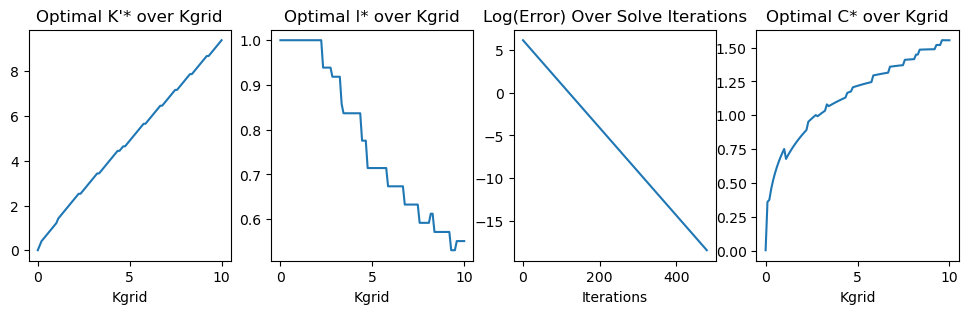

In [37]:
#Plot evolution of k*, l*, and errors (VFI)
fig, ax = plt.subplots(1,4, figsize=(12,3))

ax[0].plot(kgrid, kgrid[kpol.astype(int)] , label = "k'* policy")
ax[0].set_xlabel("Kgrid")
ax[0].set_title("Optimal K'* over Kgrid")

ax[1].plot(kgrid, lgrid[lpol.astype(int)], label = "l* policy")
ax[1].set_xlabel("Kgrid")
ax[1].set_title("Optimal l* over Kgrid")

ax[2].plot(range(count), np.log(error_bin), label = "Error")
ax[2].set_xlabel("Iterations")
ax[2].set_title("Log(Error) Over Solve Iterations")
#ax[2].set_ylabel("Maximum Absolute Distance (Element-wise)")

ax[3].plot(kgrid, cstar, label = "Consumption")
ax[3].set_xlabel("Kgrid")
ax[3].set_title("Optimal C* over Kgrid")

plt.show()

#### Q1 (b) Solve this problem using policy function iteration. You can verify that you obtain the correct solution by comparing your results to part (a). Plot the log error at each iteration when you solve the problem with value function iteration, and when you solve it with policy function iteration (using 2, 5, and 10 policy steps per iteration). Interpret your results. What does this tell us about the relative rates of convergence? Does this translate to runtime speed?

In [38]:
#Additional policy step: condition the bellman equation with the policy from the previous solve iteration.

def policy_step(P, kgrid, lgrid, kpol, lpol, V0):
    β,δ,σ,A,Λ,φ,α = P.values()
    V = np.empty_like(V0)
    
    kstar = kgrid[kpol.astype(int)]    #the (k'*,l*) that correspond to our policy
    lstar = lgrid[lpol.astype(int)]
    
    z = F(kgrid, lstar, A, α) + (1-δ)*kgrid   #Calculate output for each ki in kgrid, given the policies from the last solve iteration
    c = z - kstar
    utility = u(c, lstar, σ, Λ, φ)  
    life_util = utility + β*V0[kpol.astype(int)]   #Calculate lifetime utility, with previous values selected according to the previous policy
    V = life_util
    
    return V


#Test the function
kgrid = np.linspace(1e-8, 10, 100)    
lgrid = np.linspace(1e-8, 1, 50)
V0 = np.zeros_like(kgrid)    

midstep = policy_step(P, kgrid, lgrid, kpol, lpol, V0)
print(midstep)

[-464.82565775   -3.4471022    -3.33586168   -2.86684953   -2.60069089
   -2.42385412   -2.29549094   -2.19686552   -2.11802713   -2.0531397
   -1.99852522   -2.14342621   -2.08997551   -2.04337847   -2.00230515
   -1.96575986   -1.93298059   -1.90337314   -1.87646645   -1.85188175
   -1.82931054   -1.80849872   -1.78923487   -1.65721975   -1.64295907
   -1.62960056   -1.61705622   -1.60524962   -1.59407152   -1.58335904
   -1.57321967   -1.56360671   -1.55447867   -1.45476387   -1.44749283
   -1.44055502   -1.43392854   -1.42759282   -1.4215292    -1.41572064
   -1.41015159   -1.40480782   -1.39967627   -1.39474493   -1.3132263
   -1.3092812    -1.30548314   -1.23121968   -1.22820347   -1.22529746
   -1.22249659   -1.21979614   -1.21719168   -1.21467908   -1.21225445
   -1.20991415   -1.20765474   -1.205473     -1.14114888   -1.13944244
   -1.13779615   -1.13620784   -1.13467548   -1.1331971    -1.13177086
   -1.13039501   -1.1290679    -1.07150946   -1.07050832   -1.06954617
   -1.06

In [39]:
#Bringing it all together: VFI + Policy Step = Policy Function Iteration (PFI)

def solve_pfi(P, kgrid, lgrid, V0, tol, steps):
    '''steps := Number of policy function iterations between each bellman step'''
    
    error_bin = []
    count = 0
    V_prev = V0
    
    while True:
        count += 1
        V, kpol, lpol, cstar = update_bellman(P, kgrid, lgrid, V0)
        V0 = V
        for i in range(steps):
            V0 = policy_step(P, kgrid, lgrid, kpol, lpol, V0)
        error = np.abs(V-V_prev).max()
        error_bin.append(error)
        print(f"Iteration: {count} | Error: {error:.9f}", end="\r")
        V_prev = V
        
        if error < tol:
            break 
        if count > 1000:
            print("Maximum iterations exceeded")
            break
    return (V, kpol, lpol, count, error_bin, cstar)


#Test the function
kgrid = np.linspace(1e-5, 10, 100)    
lgrid = np.linspace(1e-5, 1, 50)
V0 = np.zeros_like(kgrid)       
tol=1e-8

qe.tic()
V, kpol, lpol, count, error_bin, cstar = solve_pfi(P, kgrid, lgrid, V0, tol, steps=2)
time = qe.toc(verbose=False)

print(f"V: {V}")
print()
print(f"k' policy: {kpol}")
print()
print(f"l policy: {lpol}")
print()
print(f"Optimal C: {cstar}")
print()
print("--------------Performance--------------")
print(f"Maximum Error: {np.max(error_bin)}")
print(f"Minimum Error: {np.min(error_bin)}")
print(f"Num Iterations: {count}")
print(f"Time Elapsed: {time}")

V: [-941.67264485  -36.39993243  -34.68731018  -33.69877277  -33.00159364
  -32.45469107  -32.0009722   -31.61142264  -31.26893909  -30.96270067
  -30.68517774  -30.43112282  -30.19648142  -29.97928481  -29.77652876
  -29.5858009   -29.40622175  -29.23602887  -29.073731    -28.91920445
  -28.77121948  -28.62870218  -28.49192105  -28.35990638  -28.23179517
  -28.10809262  -27.98824985  -27.87209813  -27.75915234  -27.64931528
  -27.54219139  -27.43784966  -27.33576064  -27.23604608  -27.13819236
  -27.04284223  -26.94977659  -26.85878797  -26.76967961  -26.68226407
  -26.59636195  -26.51180081  -26.42841407  -26.34604016  -26.26452165
  -26.18562009  -26.10965919  -26.03539578  -25.96182934  -25.88903521
  -25.81707993  -25.74602197  -25.67591245  -25.60679582  -25.53871039
  -25.47168894  -25.40575916  -25.34094413  -25.27662014  -25.21333942
  -25.15058534  -25.08888035  -25.0277316   -24.96763348  -24.90811593
  -24.84964687  -24.79177808  -24.73421973  -24.67767297  -24.62173546
  -

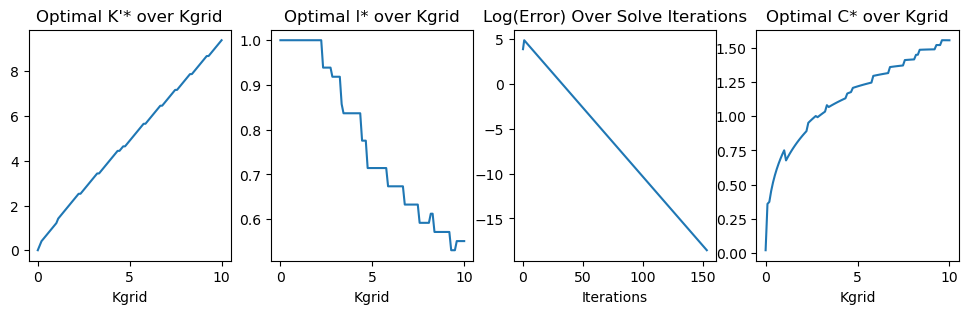

In [41]:
#Plot evolution of k*, l*, and errors (PFI)
fig, ax = plt.subplots(1,4, figsize=(12,3))

ax[0].plot(kgrid, kgrid[kpol.astype(int)] , label = "k'* policy")
ax[0].set_xlabel("Kgrid")
ax[0].set_title("Optimal K'* over Kgrid")

ax[1].plot(kgrid, lgrid[lpol.astype(int)], label = "l* policy")
ax[1].set_xlabel("Kgrid")
ax[1].set_title("Optimal l* over Kgrid")

ax[2].plot(range(count), np.log(error_bin), label = "Error")
ax[2].set_xlabel("Iterations")
ax[2].set_title("Log(Error) Over Solve Iterations")
#ax[2].set_ylabel("Maximum Absolute Distance (Element-wise)")

ax[3].plot(kgrid, cstar, label = "Consumption")
ax[3].set_xlabel("Kgrid")
ax[3].set_title("Optimal C* over Kgrid")

plt.show()

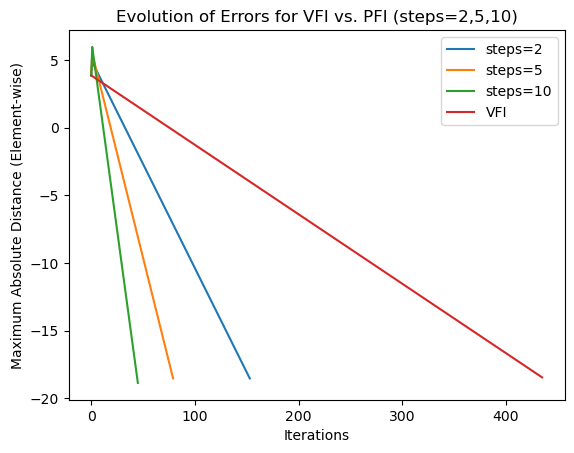

In [44]:
#Plot evolution of errors for VFI vs. PFI (steps=2,5,10)

steps = [2,5,10]
fig, ax = plt.subplots()

for i in steps:
    V, kpol, lpol, count, error_bin, cstar = solve_pfi(P, kgrid, lgrid, V0, tol, steps=i)
    ax.plot(range(count), np.log(error_bin), label=f"steps={i}")
V, kpol, lpol, count, error_bin, cstar = solve(P, kgrid, lgrid, V0, tol)
ax.plot(range(count), np.log(error_bin), label="VFI")
ax.set_title("Evolution of Errors for VFI vs. PFI (steps=2,5,10)")
ax.set_xlabel("Iterations")
ax.set_ylabel("Maximum Absolute Distance (Element-wise)")
plt.legend()
plt.show()

#### Q1 (c) Rather than using a grid search, interpolate the values of v using cubic splines, and use your favorite continuous optimization algorithm to solve the maximization problem. Plot the relevant policy functions. How many grid points do you need to get a reasonably accurate solution? What does this do to your runtime? If you’re feeling ambitious, try implementing policy function iteration here as well.3 Discuss your results.

In [53]:
#Redefine the bellman to use continuous optimization

def update_bellman(P, kgrid, lgrid, V0):
    β,δ,σ,A,Λ,φ,α = P.values()
    
    V0_interp = CubicSpline(kgrid, V0)
    
    V = np.zeros_like(V0)
    kpol = np.zeros_like(kgrid)
    lpol = np.zeros_like(kgrid)        
    
    for i, ki in enumerate(kgrid):           
        
        def objective(choice):
            kp, l = choice
            z = F(ki, l, A, α) + (1-δ)*ki 
            c = z - kp
            utility =  u(c, l, σ, Λ, φ)
            life_util = utility + β*V0_interp(kp)
            return -life_util
        
        res = minimize(objective, x0=[0,lgrid.max()*1/2], bounds=[(kgrid.min(),kgrid.max()),(lgrid.min(),lgrid.max())], method = 'L-BFGS-B')
        
        V[i] = -res.fun
        kpol[i] = res.x[0]
        lpol[i] = res.x[1]

    return V, kpol, lpol

kgrid = np.linspace(1e-8, 10, 10)      #k,l > 0 or else fails to converge (NaN errors)  
lgrid = np.linspace(1e-8, 1, 5)
V0 = np.zeros_like(kgrid)            #Initial guess

V, kpol, lpol = update_bellman(P, kgrid, lgrid, V0)
print(f"V: {V}")
print(f"k' policy: {kpol}")
print(f"l policy: {lpol}")
    

V: [-4.64825658e+02 -7.65167755e-01 -4.39077245e-01 -3.04216211e-01
 -2.31713511e-01 -1.86783189e-01 -1.56316289e-01 -1.34335933e-01
 -1.17745787e-01 -1.04787078e-01]
k' policy: [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
l policy: [1.         0.25396581 0.10359784 0.05355281 0.03208628 0.02119508
 0.01498566 0.01113197 0.00858581 0.00681845]


In [56]:
#Step 2 of VFI: iterate update_bellman() until V converges

def solve(P, kgrid, lgrid, V0, tol):
    error_bin = []
    count = 0
    while True:
        count += 1
        V, kpol, lpol = update_bellman(P, kgrid, lgrid, V0)
        error = np.abs(V-V0).max()
        error_bin.append(error)
        print(f"Iteration: {count} | Error: {error:.9f}", end="\r")
        V0 = V
        
        if error < tol:
            break 
        if count > 1000:
            print("\nMaximum iterations exceeded")
            break
    return (V, kpol, lpol, count, error_bin)


#Test the function
kgrid = np.linspace(1e-8, 10, 10)      #k,l > 0 or else fails to converge (NaN errors)  
lgrid = np.linspace(1e-8, 1, 5)
V0 = np.zeros_like(kgrid)            #Initial guess
tol=1e-8

qe.tic()
V, kpol, lpol, count, error_bin  = solve(P, kgrid, lgrid, V0, tol)
time = qe.toc(verbose=False)

print(f"V: {V}")
print()
print(f"k' policy: {kpol}")
print()
print(f"l policy: {lpol}")
print()
print("--------------Performance--------------")
print(f"Maximum Error: {np.max(error_bin)}")
print(f"Minimum Error: {np.min(error_bin)}")
print(f"Num Iterations: {count}")
print(f"Time Elapsed: {time}")

V: [-9296.51315481 -8832.50866793 -8832.26412602 -8832.16664439
 -8832.11338691 -8832.07960818 -8832.05619635 -8832.0389798
 -8832.02576973 -8832.01530402]

k' policy: [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]

l policy: [1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]

--------------Performance--------------
Maximum Error: 464.8256577497039
Minimum Error: 9.928044164553285e-09
Num Iterations: 480
Time Elapsed: 10.571179151535034


The behavior of this interpolated solving step is somewhat perplexing. It fails to converge to a solution unless the initial guess is set around (0, median(lgrid)). Additionally, the first values appear to coincide with the brute force method, but all subsequent values differ considerably. It is likely that there is an error in the way we're iterating over update_bellman() in the solving step, but it eludes us at this moment. 

#### Q1. (d)  Use your policy functions to calculate the steady state of this model. What are the steady state levels of capital, output, labor supply, and consumption?

#### Q1. (e) Suppose that we perturb k away from its steady state value of k?. That is, consider an economy that starts with k0 = 0.7k?. Plot the impulse response functions4 of capital, labor, output, and consumption,as the economy converges to its steady state. Discuss your results.

### Question 2 - Stochastic Income

#### Q2 (a) Solve this problem using any method that we have learned (value function iteration, policy function iteration, grid searches, interpolation, etc...).5 You will need to determine how many grid points are necessary, and determine appropriate bounds on the asset grid.6 Discuss the choices you made, and defend why you made them. Plot the relevant policy functions in a sensible way, and discuss the results. In particular, you should plot consumption as a share of available resources. What stands out to you?

For this problem we decided to use Value Function Iteration for simplicity. We deemed it as the most intuitive approach to the problem. 

In [16]:
# Importing Packages
import quantecon as qe 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Initializing parameters
beta = 0.95
r = 0.04
mu = 0.5
rho = 0.8
var = 0.1
sigma = 2

params = [beta, r, mu, rho, var,sigma]

In [18]:
# Definition of functions

# Definition of the utility function
def u(c):
    utility = (c**(1-sigma))/(1-sigma) 
    return np.where(c>0, utility, float("-inf")) # returning a utility of zero if consumption is negative

# Defintion of the update bellman function 
def update_bellman2(params, V, policy, optimal_consumption, agrid, ygrid, EV):
    for i in range(len(agrid)):
        a = agrid[i] # Choosing a starting asset value
        for j in range((len(ygrid))):
            Y = np.exp(ygrid[j]) # Choosing a value for income
            
            z = (1+r)*a + (Y) 
            c = z - agrid # Potential possible values of consumption for given a primes

            value = u(c) + beta * EV[:, j] # Potential Utilities
                    
            V[i, j] = np.max(value) # Storing the max value
            location = np.argmax(value) # location of the a prime that maximises utility 
            policy[i, j] = agrid[location] # Storing the optimal a prime
            consumption = (1+r)*a + Y - agrid[location] # Calculating consumption given optimal choices
            optimal_consumption[i,j] = consumption
    return 

# Definition of the solve function 
def solve_vfi2(params, agrid, V0,ny, tol = 1e-12, maxiter = 1000):
    V0 = np.copy(V0)
    beta, r, mu, rho, var, σ = params #unpacking parameter
    V = np.copy(V0)
    errors  = []  #creating bin for errors
    iter    = 0

    # Discretize the income process
    mc = qe.markov.approximation.rouwenhorst(n = ny,ybar = 0.5,sigma=0.1, rho = 0.8) #implementing the rouwenhorst method from quantecon
    P = np.transpose(mc.P) 
    ygrid   = mc.state_values # taking the y grid from the approximation
    #Initialising guesses
    V = np.zeros((len(agrid), len(ygrid))) 
    policy = np.zeros((len(agrid), len(ygrid))) 
    optimal_consumption = np.zeros((len(agrid), len(ygrid)))
    while True: #running model until errors are smaller than tolerance
        iter += 1 
        
        EV = np.matmul(V0,P) #calculating expected values for the update bellman function

        update_bellman2(params, V, policy, optimal_consumption, agrid, ygrid, EV)

        error = np.max(np.abs(V - V0))
        errors.append(error)
        if error < tol:
            break 
        V0 = V.copy()
        if iter > 1000: #including break if the model fails to converge
            print("Maximum iterations exceeded")
            break
        V0 = V.copy()

    return (V, policy, optimal_consumption, iter, errors, agrid, ygrid) #returning all the outputs we are interested in

To asses the optimal bounds of our asset grid we can plot our consumption paths for the person with the maximum income to see if there choice of a prime is being bounded by agrid.

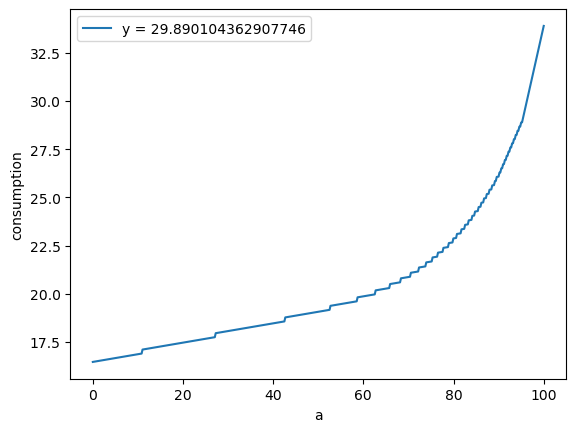

In [19]:
# Solving the problem
ny = 30 
na = 500
agrid = np.linspace(1e-6, 100, na)  
V0 = np.zeros((na,ny))
solution = solve_vfi2(params, agrid, V0,ny, tol = 1e-3, maxiter = 1000)

# Taking the values for optimal consumption and the ygrid from the solve_vfi2 function 
consumption = solution[2]
ygrid = solution[6]

#Plotting the optimal consumption vs a for the highest possible starting value of y we have on our grid
fig, ax = plt.subplots()
ax.plot(agrid, consumption[:,29], label = f'y = {np.exp(ygrid[29])}') 
ax.set_ylabel('consumption')
ax.set_xlabel('a')
plt.legend()
plt.show()

To check whether our grid points and the bounds of our asset grid make sense we plot the consumption decisions of the individuals with highest income, denoted by the final index of the income grid. We can see that after a certain point consumption begins to increase vertically which implies that the individual would prefer to choose a greater a' but is being bound by the potential range of a'. This implies that we should choose a larger range of a'. For a ny of 30 we set a max value of a = 500 we that the individual can now choose their desired a'.

In [20]:
# Solving the model with agrid bounded by 500
ny = 30
na = 500
agrid = np.linspace(1e-6, 500, na)  
V0 = np.zeros((na,ny))
solution = solve_vfi2(params, agrid, V0,ny, tol = 1e-3, maxiter = 1000)

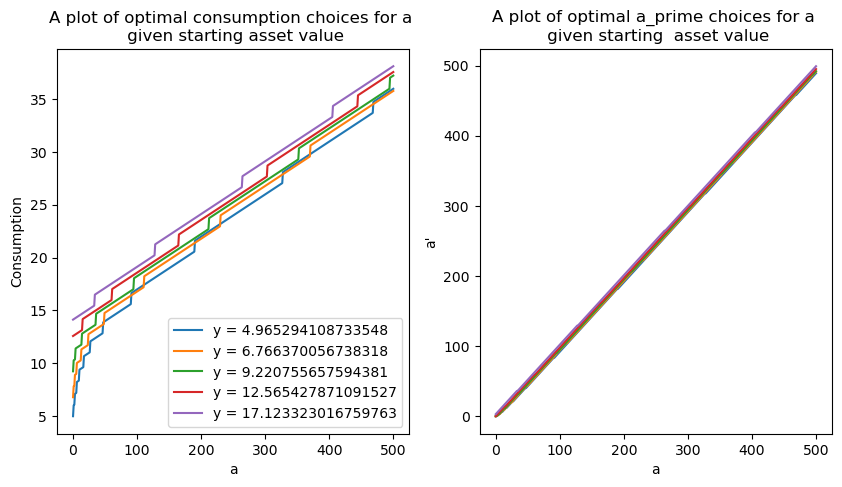

In [21]:
# Plots of our Policy values for consumption and a'
Aprime = solution[1] #retrieving the optimal a' values
consumption = solution[2] # retrieving optimal consumption values
ygrid = solution[6] 
Y = [0,5,10,15,20] # setting different indices of the ygrid for plot comparisons

# Consumption increases at the bound as they cant choose a large enough a prime
fig, ax = plt.subplots(1,2, figsize = (10,5))
for i in Y:
    ax[0].plot(agrid, consumption[:, i], label = f'y = {np.exp(ygrid[i])}')
    ax[0].set_ylabel('Consumption')
    ax[0].set_xlabel('a')
    ax[0].set_title('A plot of optimal consumption choices for a \n given starting asset value')
    ax[0].legend()


for i in Y:
    ax[1].plot(agrid, Aprime[:, i], label = f'y = {np.exp(ygrid[i])}')
    ax[1].set_ylabel('a\'')
    ax[1].set_xlabel('a')
    ax[1].set_title('A plot of optimal a_prime choices for a \n given starting  asset value')
plt.show()

The plots above indicate an interesting point. The highest variety in consumption is observed at the lowest part of the asset endowment, while from around a>100 we see that differences between labour income do not play such a significant role in consumption. In terms of a' we see that it is a linear function of a. This would imply that individuals simply consume their income and the return on their assets in one period and maintain approximately their initial asset endowment for the next in a two period setting.

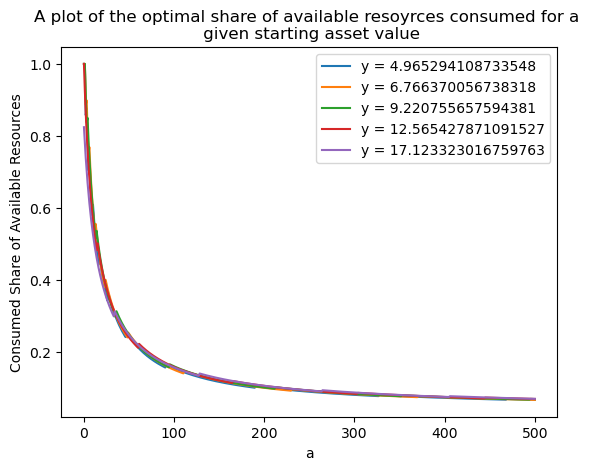

In [22]:
# Calculating Incomes
income = np.zeros((len(agrid),len(ygrid)))
for i in range(len(agrid)):
    for j in range(len(ygrid)): 
        a = agrid[i]
        y = ygrid[j]
        income[i,j] = (1+r)*a + np.exp(y) 
        
Consumption_share  = consumption / income 

# Plot of consumption share of income
fig, ax = plt.subplots()
for i in Y:
    ax.plot(agrid, Consumption_share[:, i], label = f'y = {np.exp(ygrid[i])}')
ax.set_ylabel('Consumed Share of Available Resources')
ax.set_xlabel('a')
ax.set_title('A plot of the optimal share of available resoyrces consumed for a \n given starting asset value')
ax.legend()
plt.show()

The plot above illustrates the fact that individuals consume roughly the same share of income regardless of their labour income. The only thing which appears to influence the consumption share of income is their initial asset endowment. With a very high initial endowment relative to labour income individuals save most of their total income for the next period to maintain their consumption across time. What is however interesting is that zooming in at the low endowment part of the curve we see some disparities. Here the individuals with the lowest labour income make no savings, whereas those with higher incomes manage to save some income and move a to a'.

#### Q2 (b) Suppose you are given an initial starting point (a0, y0). You can simulate a sample worker history by repeatedly evaluating the policy rules, and taking random draws for y0. 7 Start from a0 at the midpoint of your asset grid, and y0 from the midpoint of your income grid. Simulate 5 sample paths and of assets, income and consumption, for 100 model periods. Plot them together (you should have three graphs, side-by-side, with 5 lines on each one). Discuss what the results look like.

In [23]:
V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

#Create empty bins
A_bin = []
C_bin = []
Y_bin = []

# Starting values
a0p = 200
y0 = 15
# First position on the asset grid
a_next = policy[a0p ,y0]
# For loop for 5 individuals
for i in range(5):
    a_bin = []
    c_bin = []
    y_bin = []
    cons = (1+r)*agrid[a0p] + np.exp(ygrid[y0]) - agrid[int(a_next)] #consumption
    #loop over 100 periods
    for i in range(0,100):
        y_rand = np.random.randint(0,29) #randomize income for each period
        y_bin.append(np.exp(ygrid[y_rand]))
        a_previous = int(a_next)
        a_next = policy[int(a_next), y_rand]
        a_bin.append(a_next)
        consumption = (1+r)*agrid[a_previous] + np.exp(ygrid[y_rand]) - agrid[int(a_next)] #calculate consumption for each period
        c_bin.append(consumption)
    A_bin.append(a_bin)
    C_bin.append(c_bin)
    Y_bin.append(y_bin)

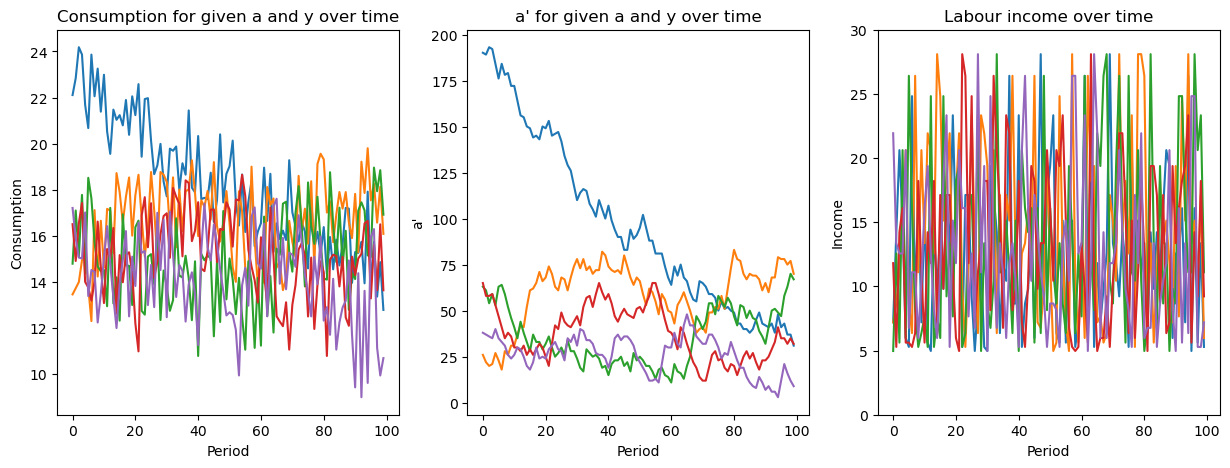

In [24]:
# Plots for Consumption, a' and Income
fig, ax = plt.subplots(1,3, figsize = (15,5)) 
for i in range(5):
    ax[0].plot(range(100), C_bin[i])
    ax[0].set_ylabel('Consumption')
    ax[0].set_xlabel('Period')
    ax[0].set_title('Consumption for given a and y over time')


for i in range(5):
    ax[1].plot(range(100), A_bin[i])
    ax[1].set_ylabel('a\'')
    ax[1].set_xlabel('Period')
    ax[1].set_title('a\'' ' for given a and y over time')
    
for i in range(5):
    ax[2].plot(range(100), Y_bin[i])
    ax[2].set_ylabel('Income')
    ax[2].set_xlabel('Period')
    ax[2].set_title('Labour income over time')
    plt.ylim(0,30)
plt.show()

As we can see on the charts above consumption appears to decline over time for the individual with the highest initial consumption, whereas the other 4 consumptions appear not to have any particular trend after around 20 periods. The same appears to be the case for a'. It is as though each individual has some optimal asset level which is optimal given the labour income distribution. The labour income over time is just a distribution we obtained from the rouwenhorts method which is between 5 and 29. All in all there appears to be a consumption-savings equilibrium which is reached regardless of initial decisions for all individuals.

#### Q2 (c) Now let’s try this for 10,000 workers.8 Initialize the worker states in any way you like. Simulate the population forward for 100 periods, and plot a histogram with the distribution of assets. Try stepping the population forward another 100 periods. Is the distribution changing very much? Can you figure out a way to discuss what it would mean to say that the distribution has converged?

In [25]:
# For 100 periods
dist_bin_100 = []
for i in range(10000):
    for i in range(0,100):
        y_rand = np.random.randint(0,29) 
        a_next = policy[int(a_next), y_rand] 
        a = agrid[int(a_next)]
    dist_bin_100.append(a)   
    
# For 200 periods
dist_bin_200 = []
for i in range(10000):
    for i in range(0,200):
        y_rand = np.random.randint(0,29) 
        a_next = policy[int(a_next), y_rand] 
        a = agrid[int(a_next)]
    dist_bin_200.append(a)    
    
# For 300 periods
dist_bin_300 = []
for i in range(10000):
    for i in range(0,300):
        y_rand = np.random.randint(0,29) 
        a_next = policy[int(a_next), y_rand] 
        a = agrid[int(a_next)]
    dist_bin_300.append(a) 

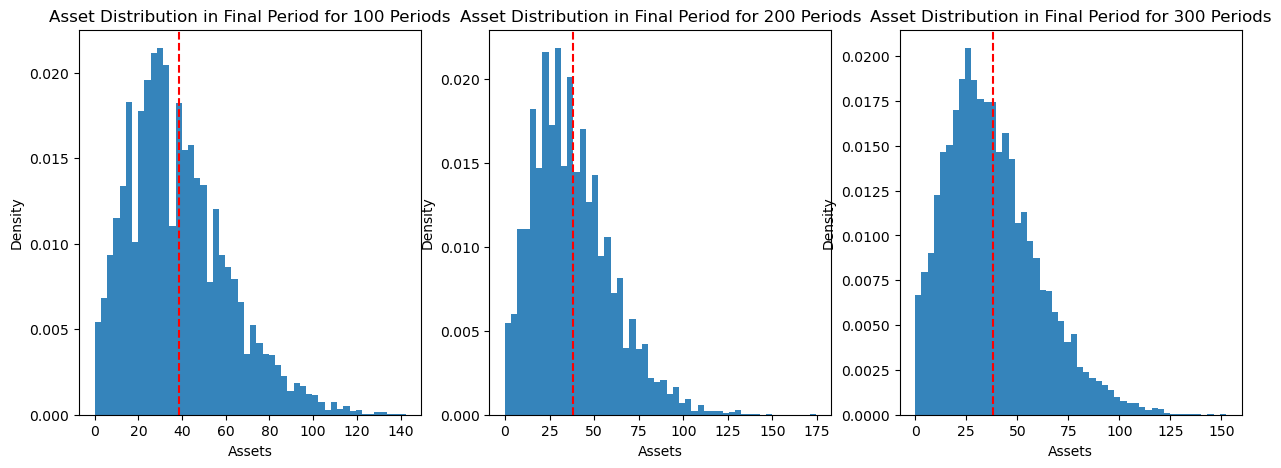

In [26]:
#Plot
Average_assets_100 = np.mean(dist_bin_100) # include average assets for reference

fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].hist(dist_bin_100, density=True, bins=50, alpha = 0.9)
ax[0].axvline(np.mean(dist_bin_100), color = 'r', linestyle = 'dashed')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Assets')
ax[0].set_title('Asset Distribution in Final Period for 100 Periods')

ax[1].hist(dist_bin_200, density=True, bins=50, alpha = 0.9)
ax[1].axvline(np.mean(dist_bin_200), color = 'r', linestyle = 'dashed')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Assets')
ax[1].set_title('Asset Distribution in Final Period for 200 Periods')

ax[2].hist(dist_bin_300, density=True, bins=50, alpha = 0.9)
ax[2].axvline(np.mean(dist_bin_300), color = 'r', linestyle = 'dashed')
ax[2].set_ylabel('Density')
ax[2].set_xlabel('Assets')
ax[2].set_title('Asset Distribution in Final Period for 300 Periods')
plt.show()

As we can see on the charts above the distributions of assets appear to be very similar regardless of the periods in the simulation. The reason for this could be that individuals after a relatively short period reach a particular level of assets which allows them to sustain their consumption patterns, given interest rates and their discount factor.

#### (d) For the ambitious among you: Suppose the government decided to tax income (both earned interest ra and labor income y) at a rate of 25% to finance government expenditures. Re-solve the model with this tax rate, and compare the results. How does the distribution of assets change? How much revenue does this raise every period?


For this part we attempt to introduce the tax in the z in the bellman equation. We subtract it from asset income and labour income. Due to limited time this week we did not proceed to calculate the tax revenue and part e. Nonetheless we wanted to try and see what impact would a blanket income tax have on our results.

In [27]:
# Defintion of the update bellman function with taxes
def update_bellman3(params, V, policy, optimal_consumption, agrid, ygrid, EV, tax = 0.25):
    for i in range(len(agrid)):
        a = agrid[i] # Choosing a starting asset value
        for j in range((len(ygrid))):
            Y = np.exp(ygrid[j]) # Choosing a value for income
            
            z = ((1+(1-tax)*r)*a + (1-tax)*(Y)) # We subtract the tax from asset and labour income
            c = z - agrid # Potential possible values of consumption for given a primes

            value = u(c) + beta * EV[:, j] # Potential Utilities
                    
            V[i, j] = np.max(value) # Storing the max value
            location = np.argmax(value) # location of the a prime that maximises utility 
            policy[i, j] = agrid[location] # Storing the optimal a prime
            consumption = (1+r)*a + Y - agrid[location] # Calculating consumption given optimal choices
            optimal_consumption[i,j] = consumption
    return 

In [28]:
# Redefinition of the solve function with updated bellman.
def solve_vfi3(params, agrid, V0,ny, tol = 1e-12, maxiter = 1000):
    V0 = np.copy(V0)
    beta, r, mu, rho, var, σ = params #unpacking parameter
    V = np.copy(V0)
    errors  = []  #creating bin for errors
    iter    = 0

    # Discretize the income process
    mc = qe.markov.approximation.rouwenhorst(n = ny,ybar = 0.5,sigma=0.1, rho = 0.8) #implementing the rouwenhorst method from quantecon
    P = np.transpose(mc.P) 
    ygrid   = mc.state_values # taking the y grid from the approximation
    #Initialising guesses
    V = np.zeros((len(agrid), len(ygrid))) 
    policy = np.zeros((len(agrid), len(ygrid))) 
    optimal_consumption = np.zeros((len(agrid), len(ygrid)))
    while True: #running model until errors are smaller than tolerance
        iter += 1 
        
        EV = np.matmul(V0,P) #calculating expected values for the update bellman function

        update_bellman3(params, V, policy, optimal_consumption, agrid, ygrid, EV, tax=0.25)

        error = np.max(np.abs(V - V0))
        errors.append(error)
        if error < tol:
            break 
        V0 = V.copy()
        if iter > 1000: #including break if the model fails to converge
            print("Maximum iterations exceeded")
            break
        V0 = V.copy()

    return (V, policy, optimal_consumption, iter, errors, agrid, ygrid) #returning all the outputs we are interested in

In [29]:
# Resolve model with tax
ny = 30
na = 500
agrid = np.linspace(1e-6, 500, na)  
V0 = np.zeros((na,ny))
solution = solve_vfi3(params, agrid, V0,ny, tol = 1e-3, maxiter = 1000)

In the cells above we resolve the model with the new tax. Below we simulate consumption, assets and labour income for 5 individuals for 100 periods. Here we changed the cons equation to reflect the introduction of the tax.

In [30]:
V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

#Create empty bins
A_bin = []
C_bin = []
Y_bin = []

# Starting values
a0p = 200
y0 = 15
# First position on the asset grid
a_next = policy[a0p ,y0]
# For loop for 5 individuals
for i in range(5):
    a_bin = []
    c_bin = []
    y_bin = []
    cons = (1+(1-0.25)*r)*agrid[a0p] + (1-0.25)*np.exp(ygrid[y0]) - agrid[int(a_next)] #consumption including tax
    #loop over 100 periods
    for i in range(0,100):
        y_rand = np.random.randint(0,29) #randomize income for each period
        y_bin.append(np.exp(ygrid[y_rand]))
        a_previous = int(a_next)
        a_next = policy[int(a_next), y_rand]
        a_bin.append(a_next)
        consumption = (1+r)*agrid[a_previous] + np.exp(ygrid[y_rand]) - agrid[int(a_next)] #calculate consumption for each period
        c_bin.append(consumption)
    A_bin.append(a_bin)
    C_bin.append(c_bin)
    Y_bin.append(y_bin)

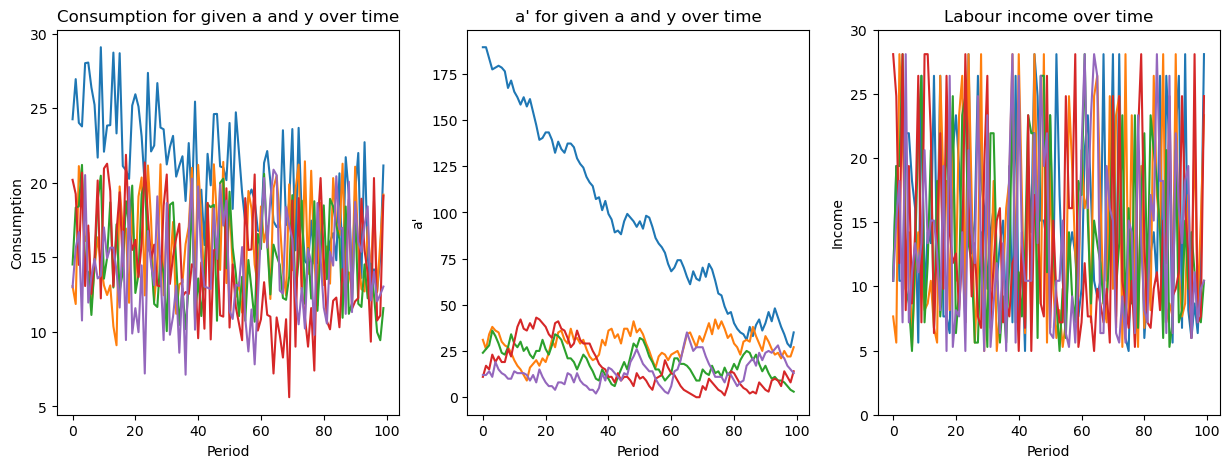

In [31]:
# Plots for Consumption, a' and Income
fig, ax = plt.subplots(1,3, figsize = (15,5)) 
for i in range(5):
    ax[0].plot(range(100), C_bin[i])
    ax[0].set_ylabel('Consumption')
    ax[0].set_xlabel('Period')
    ax[0].set_title('Consumption for given a and y over time')


for i in range(5):
    ax[1].plot(range(100), A_bin[i])
    ax[1].set_ylabel('a\'')
    ax[1].set_xlabel('Period')
    ax[1].set_title('a\'' ' for given a and y over time')
    
for i in range(5):
    ax[2].plot(range(100), Y_bin[i])
    ax[2].set_ylabel('Income')
    ax[2].set_xlabel('Period')
    ax[2].set_title('Labour income over time')
    plt.ylim(0,30)
plt.show()

The graphs of consumption and income appear to be very similar to the no tax case, the slope of the decline in consumption appears to be similar. The biggest change is found in the a' plot. Now we observe significantly sharper falls in a' compared to the no tax case. We believe this is the case because of the decrease in the benefits of savings. In essence the tax reduces the interest rate, which impacts the savings decisions and makes consumption more attractive. The consumer retains similar consumption patterns to the no tax case, but resorts to eating away assets to finance this.

In [32]:
#Once again simulate asset distribution

V, policy, optimal_consumption, iter, errors, agrid, ygrid = solution

# For 100 periods
dist_bin_100 = []
for i in range(10000):
    for i in range(0,100):
        y_rand = np.random.randint(0,29) 
        a_next = policy[int(a_next), y_rand] 
        a = agrid[int(a_next)]
    dist_bin_100.append(a)   
    
# For 200 periods
dist_bin_200 = []
for i in range(10000):
    for i in range(0,200):
        y_rand = np.random.randint(0,29) 
        a_next = policy[int(a_next), y_rand] 
        a = agrid[int(a_next)]
    dist_bin_200.append(a)    
    
# For 300 periods
dist_bin_300 = []
for i in range(10000):
    for i in range(0,300):
        y_rand = np.random.randint(0,29) 
        a_next = policy[int(a_next), y_rand] 
        a = agrid[int(a_next)]
    dist_bin_300.append(a) 

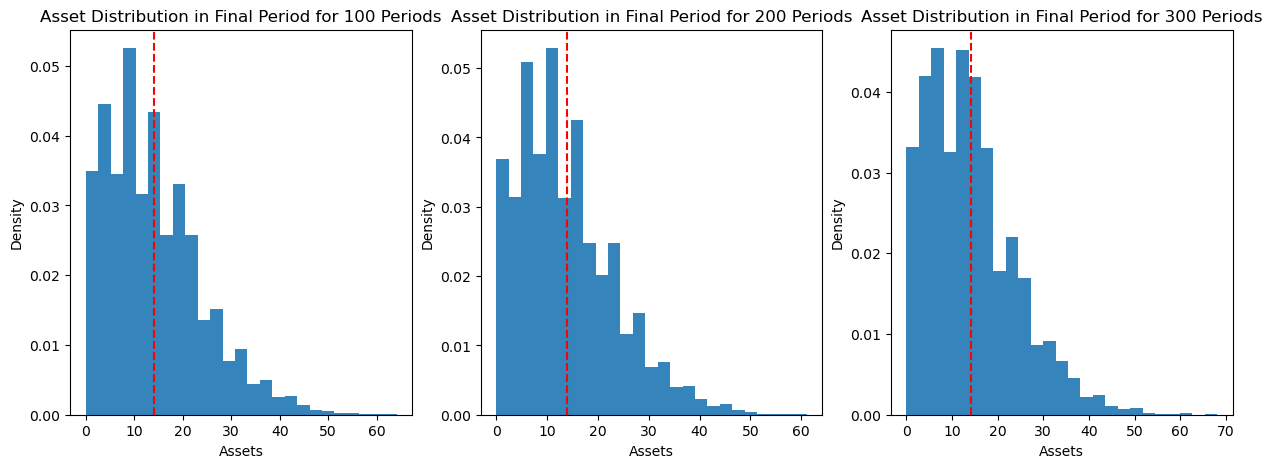

In [33]:
# Plot asset distribution with tax on all income
Average_assets_100 = np.mean(dist_bin_100)

fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].hist(dist_bin_100, density=True, bins=25, alpha = 0.9)
ax[0].axvline(np.mean(dist_bin_100), color = 'r', linestyle = 'dashed')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('Assets')
ax[0].set_title('Asset Distribution in Final Period for 100 Periods')

ax[1].hist(dist_bin_200, density=True, bins=25, alpha = 0.9)
ax[1].axvline(np.mean(dist_bin_200), color = 'r', linestyle = 'dashed')
ax[1].set_ylabel('Density')
ax[1].set_xlabel('Assets')
ax[1].set_title('Asset Distribution in Final Period for 200 Periods')

ax[2].hist(dist_bin_300, density=True, bins=25, alpha = 0.9)
ax[2].axvline(np.mean(dist_bin_300), color = 'r', linestyle = 'dashed')
ax[2].set_ylabel('Density')
ax[2].set_xlabel('Assets')
ax[2].set_title('Asset Distribution in Final Period for 300 Periods')
plt.show()

As we see on the graphs above the distribution of assets is significantly different. The left tail is a lot heavier. In general everyone ends up with less assets than in the no tax case. This intuitively makes sense as there is more incentive to consume instead of saving as in the next period we receive a smaller benefit from retaining assets. All in all it appears that consumers utilise their savings stock to consume instead of saving for the next period.